In [1]:
%matplotlib inline

In [2]:
import pycomlink as pycml
import numpy as np

In [3]:
cml_list = pycml.io.examples.get_75_cmls()

100%|██████████| 75/75 [00:01<00:00, 70.08it/s]


In [4]:
# convert time (TODO: add this to cmlh5 parsing function)
for cml in cml_list:
    # Time is stored in seconds since epoch in cmlh5 and should be represented 
    # by np.datetime64 in nanoseconds
    cml['time'] = (cml.time.values * 1e9).astype("datetime64[ns]")

In [5]:
cml = cml_list[0]

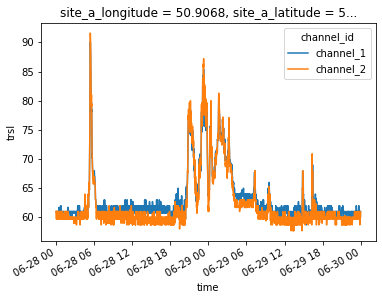

In [6]:
cml['trsl'] = cml.tsl - cml.rsl
cml.trsl.plot.line(x='time');

In [7]:
cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > 0.8

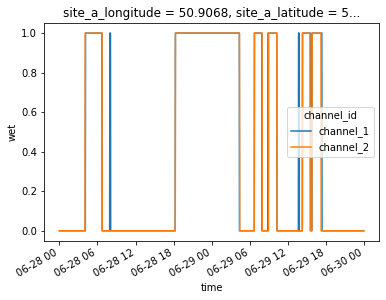

In [8]:
cml.wet.astype('float').plot.line(x='time');

In [9]:
# TODO: Allow to pass 2D arrays or even xarray Dataarrays
cml['baseline'] = ('channel_id', 'time'), np.stack([
    pycml.processing.baseline.baseline_constant(cml.isel(channel_id=0).trsl.values, cml.isel(channel_id=0).wet.values),
    pycml.processing.baseline.baseline_constant(cml.isel(channel_id=1).trsl.values, cml.isel(channel_id=1).wet.values)
])

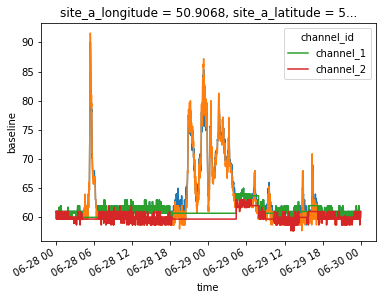

In [10]:
cml.trsl.plot.line(x='time')
cml.baseline.plot.line(x='time');

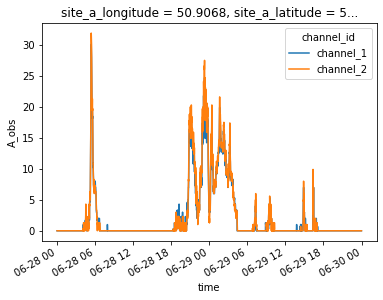

In [11]:
cml['A_obs'] = (cml.trsl - cml.baseline)
cml['A_obs'] = cml.A_obs.where(cml.A_obs >=0, 0)
cml.A_obs.plot.line(x='time');

In [12]:
# TODO: Allow to pass several channels and handle the required 1D array of frequencies
cml['waa'] = ('channel_id', 'time'), np.stack([
    pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
        A_obs=cml_ch.A_obs.values, 
        f_Hz=cml_ch.frequency.values*1e9, 
        L_km=cml_ch.length.values,
    ) for channel_name, cml_ch in cml.groupby('channel_id')
])

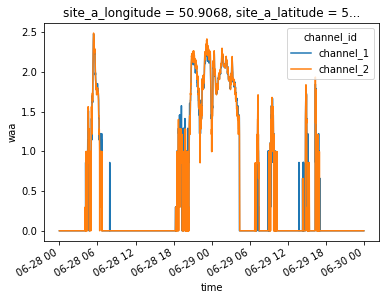

In [13]:
cml.waa.plot.line(x='time');

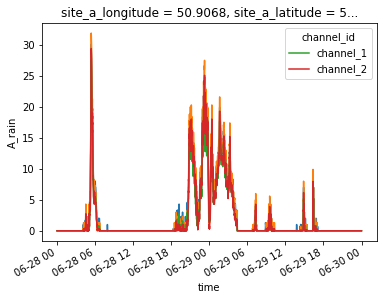

In [14]:
cml['A_rain'] = cml.A_obs - cml.waa
cml.A_obs.plot.line(x='time');
cml.A_rain.plot.line(x='time');

In [15]:
# TODO: Same as above, but also make units of L and f consistenst
cml['R'] = ('channel_id', 'time'), np.stack([
    pycml.processing.k_R_relation.calc_R_from_A(
        A=cml_ch.A_obs.values, 
        L=cml_ch.length.values,
        f_GHz=cml_ch.frequency.values,
    ) for channel_name, cml_ch in cml.groupby('channel_id')
])

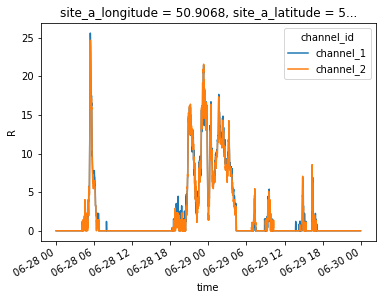

In [16]:
cml.R.plot.line(x='time');

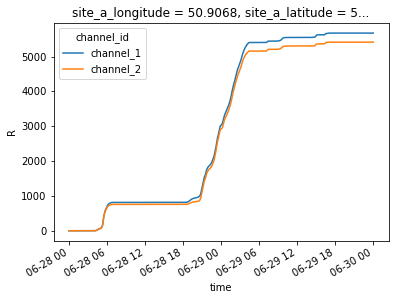

In [17]:
cml.R.cumsum(dim='time').plot.line(x='time');

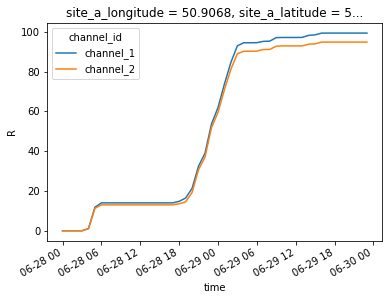

In [18]:
cml.R.resample(time='1h').mean().cumsum(dim='time').plot.line(x='time');

In [19]:
cml

<xarray.Dataset>
Dimensions:           (channel_id: 2, time: 2750)
Coordinates:
    site_a_longitude  float64 50.91
    site_a_latitude   float64 50.26
    site_b_longitude  float64 50.38
    site_b_latitude   float64 50.38
    polarization      |S1 b'V'
    cml_id            |S17 b'MY1394_2_MY2336_4'
    length            float64 13.48
  * time              (time) datetime64[ns] 2017-06-28T00:00:10.241754112 ... 2017-06-29T23:59:10.229434880
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (channel_id) float64 18.2 19.2
Data variables:
    tsl               (channel_id, time) float64 14.0 14.0 14.0 ... 14.0 13.0
    rsl               (channel_id, time) float64 -47.0 -47.0 ... -47.0 -47.0
    trsl              (channel_id, time) float64 61.0 61.0 61.0 ... 61.0 60.0
    wet               (channel_id, time) bool False False False ... False False
    baseline          (channel_id, time) float64 61.0 61.0 61.0 ... 61.0 60.0
    A_obs             (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waa               (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    A_rain            (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R                 (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0